## Modeling Jai Alai as a multiclass classification problem. 

### Exploring Magic City Casino's Jai Alai results with sklearn in Python
SPOILER: Some of the models below do perform better than the baseline classification accuracy, however the liquidity of the win-place-show pools at Magic City is so low that even a $2 bet can sometimes turn an overlay into an underlay.

I originally made this notebook in the summer of 2020 using match data scraped from Magic City's [website](https://www.magiccitycasino.com/jai-alai-entries-and-results). Although the results show promise, as mentioned new wagering activity of more than a few dollars would negatively affect the parimutuel odds.

## Load Data

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# after scraping and parsing the results pdfs, many of the games where the substitute player was used had to be edited manually
# the 'time' column refers to whether the game occured during the matinee or evening slots
## pp1 stands for 'post position 1' etc.
df = pd.read_csv('20200000_roster_subbed.csv', header=0)
df.head().T

,0,1,2,3,4
date,7/3/2019,7/3/2019,7/3/2019,7/3/2019,7/3/2019
time,1,1,1,1,1
game,1,2,3,5,6
pp1,1,1,1,1,1
name1,Fred,Fred,Bueno,Anderluck,Anderluck
pp2,2,2,2,2,2
name2,CRB,Rock,Tennessee,Juice,El Barba
pp3,3,3,3,3,3
name3,Jeden,Bueno,Rock,Kubala,Kubala
pp4,4,4,4,4,4


In [3]:
# drop everything except for player names, winner, time slot, and game no.
drop_columns = ['date','pp1','pp2','pp3','pp4','pp5','pp6','pp7','pp8','sub', 'sub_name',
                'w_post','win','w_post','win_pay','p_post','place','s_post','show','win_prob','order']
# split into X,y
X = df.drop(drop_columns, axis=1).copy() # X = time slot, game no., player names
y = df['win'].copy() # y = winner

In [4]:
X.head()

,time,game,name1,name2,name3,name4,name5,name6,name7,name8
0,1,1,Fred,CRB,Jeden,Bueno,Cool Fitness,Rock,Tennessee,Limonte
1,1,2,Fred,Rock,Bueno,CRB,Jeden,Limonte,Tennessee,Cool Fitness
2,1,3,Bueno,Tennessee,Rock,Jeden,CRB,Limonte,Cool Fitness,Fred
3,1,5,Anderluck,Juice,Kubala,Carballo,Bradley,Legend,Ben,Diaz
4,1,6,Anderluck,El Barba,Kubala,Juice,Bradley,Diaz,Carballo,Legend


In [5]:
y.head()

0        Bueno
1        Bueno
2        Bueno
3    Anderluck
4       Kubala
Name: win, dtype: object

In [6]:
y.value_counts()

Douglas         206
Bueno           119
Carballo        116
Kubala          114
RonRon          100
Tennessee        94
Ben              93
Anderluck        86
Jeden            71
Diaz             69
Ikeda            69
El Barba         67
Cool Fitness     58
Bradley          46
Juice            46
CRB              43
Legend           42
Vuelo            39
Fred             36
Limonte          26
Asier            23
Rock              5
Name: win, dtype: int64

## Encode Data

In [7]:
# import encoding libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [8]:
# one hot encode all X inputs
one_hot = OneHotEncoder()
one_hot.fit(X)
enc_X = one_hot.transform(X)

In [9]:
# run y through label encoder ()
le = LabelEncoder()
le.fit(y)
enc_y = le.transform(y)

## Get Baseline Result

When checking the y value counts earlier, since some players have won hundreds of games while others have only won a few dozen, I'll approach this as an imbalanced classification problem. Using sklearn's RepeatedStratifiedKFold can give a good general estimate of model performance by using a balanced mixture of examples by class in each fold and repeating the cross validation process many times.

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier
from numpy import mean, std

# evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=3,random_state=1)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

In [11]:
# evaluate the baseline strategy of predicting the majority class in all cases
model = DummyClassifier(strategy='most_frequent')

In [12]:
scores = evaluate_model(enc_X, enc_y, model)
# summarize performance
print(f'Mean Accuracy: {mean(scores):.4f}, Standard Deviation: {std(scores)*100:.4f}')

# note: this baseline % results from always picking the player with the most wins to win, 
#       even if that player didn't participate in the game
#       if we simply pick the post position with the most wins (no. 2) every time, the accuracy is around 16%

Mean Accuracy: 0.1314, Standard Deviation: 0.1205


## Evaluate Models

Now that we know the baseline performance, I'll compare the out of the box performance of several different algorithms to see which ones might deserve further attention:

Multi-layer Perceptron,
Support Vector Machine,
k-Nearest Neighbors,
Gradient Boost,
Random Forest,
Extra Trees,
Bagged Decision Trees, 
Logistic Regression

In [13]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

In [14]:
# define models to test
def get_models():
    models, names = list(), list()
    #Multi Layer Perceptron
    models.append(MLPClassifier())
    names.append('MLP')
    # Log. Reg. Multinomial
    models.append(LogisticRegression(multi_class='multinomial'))
    names.append('LRmulti')
    # Log. Reg. One Versus Rest
    models.append(LogisticRegression(multi_class='ovr'))
    names.append('LRovr')    
    # SVM
    models.append(SVC(gamma='auto'))
    names.append('SVM')
    # KNN
    models.append(KNeighborsClassifier())
    names.append('KNN')
    # GB
    models.append(GradientBoostingClassifier())
    names.append('GB')
    # Bagging
    models.append(BaggingClassifier(n_estimators=1000))
    names.append('BAG')
    # RF
    models.append(RandomForestClassifier(n_estimators=1000))
    names.append('RF')
    # ET
    models.append(ExtraTreesClassifier(n_estimators=1000))
    names.append('ET')
    return models, names

In [15]:
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
    # evaluate the model and store the results
    scores = evaluate_model(enc_X, enc_y, models[i])
    results.append(scores)
    # summarize performance
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))

>MLP 0.219 (0.020)
>LRmulti 0.222 (0.020)
>LRovr 0.224 (0.024)
>SVM 0.155 (0.009)
>KNN 0.167 (0.017)
>GB 0.233 (0.017)
>BAG 0.223 (0.015)
>RF 0.240 (0.017)
>ET 0.232 (0.012)


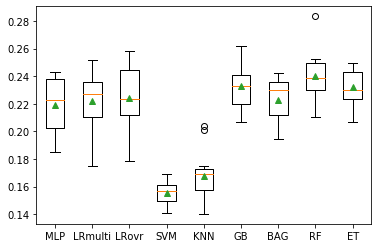

In [16]:
# show boxplot of each model's accuracy scores
# the line in the middle of the box is the sample median, the triangle the mean
plt.boxplot(results,  labels=names, showmeans=True)
plt.show()

In [17]:
# run it again for comparison
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
    # evaluate the model and store the results
    scores = evaluate_model(enc_X, enc_y, models[i])
    results.append(scores)
    # summarize performance
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))

>MLP 0.221 (0.014)
>LRmulti 0.222 (0.020)
>LRovr 0.224 (0.024)
>SVM 0.155 (0.009)
>KNN 0.167 (0.017)
>GB 0.232 (0.017)
>BAG 0.224 (0.014)
>RF 0.240 (0.018)
>ET 0.232 (0.014)


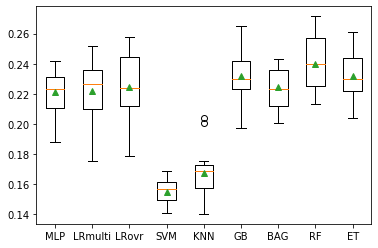

In [18]:
plt.boxplot(results,  labels=names, showmeans=True)
plt.show()

## Tune hyperparameters of the best out-of-box models

In [19]:
from sklearn.model_selection import GridSearchCV

In [20]:
# Tune logistic Regression
# define model and hyperparamaters
tune_lr = LogisticRegression()
max_iter = [100, 1000]
multiclass = ['ovr','multinomial']
solvers = ['newton-cg','lbfgs','liblinear']
penalty = ['l2']
c_values = [100,10,1.0,0.1,0.01]
# define grid search
grid = dict(max_iter=max_iter,multi_class=multiclass,solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=3,random_state=1)
grid_search = GridSearchCV(estimator=tune_lr,param_grid=grid,n_jobs=-1,cv=cv,scoring='accuracy',error_score=0)
grid_result = grid_search.fit(enc_X, enc_y)
# summarize reslts
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))

Best: 0.234065 using {'C': 0.1, 'max_iter': 100, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'newton-cg'}


In [21]:
# tune Random Forest
# define model and hyperparameters
tune_rf = RandomForestClassifier()
n_estimators = [10,100,1000]
max_features = ['sqrt', 'log2']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=tune_rf, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(enc_X, enc_y)
# summarize results
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))

Best: 0.242988 using {'max_features': 'sqrt', 'n_estimators': 1000}


In [22]:
# Tune Gradient Boost
# define models and parameters
tune_gb = GradientBoostingClassifier()
n_estimators = [50,100,200]
learning_rate = [0.01,0.1]
subsample = [0.5,1.0]
max_depth = [3,6]
# define grid search
grid = dict(learning_rate=learning_rate,n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)
cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=3,random_state=1)
grid_search = GridSearchCV(estimator=tune_gb,param_grid=grid,n_jobs=-1,cv=cv,scoring='accuracy',error_score=0)
grid_result = grid_search.fit(enc_X, enc_y)
# summarize results
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))

Best: 0.260425 using {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.5}


## Conclusion
With the help of sklearn, it didn't take much work to find a few models that perform almost 2x better than the baseline prediction rate. Further steps to improve the model would include looking at model log loss, running a regression to calculate the optimum weight of each individual model's input to the ensemble, and finally running a wagering backtest to check profitability.

It would also be worth trying to predict the winning post position (1 through 8) as opposed to trying to predict which player name out of 22 options will be the winner. The latter is problematic because sometimes the algorithms output a non-zero probability of winning for a player that isn't even participating in the match.

Since we already know that the Magic City wagering pool is too small to absorb bets of more than a few dollars though, I conclude the modeling exercise here.